# OncoDT methods.

### This notebook provides an implementation of the OncoDT tool to predict therapeutic target genes for ten cancer types. 
Each cancer has its own model and FVs. The code here read the generated embeddings for amino-acid sequences using ProtTrans-BERT embeddings. 
Several preprocessing and preparation steps have been implemented before utilizing this code for each cancer type. For example:
- A demo for how we generate BERT embeddings is provided in another file.
- All genes were read from three sources: positive targets, cancer genes, and negative genes, which are combined, shuffled and then used to generate the embeddings using their amino-acid sequences. These combined genes are saved in the Combined_Genes folder.

In [1]:
# all needed packages
import pandas as pd
import math as math
import numpy as np
import json, csv, itertools
from matplotlib import pyplot

# Machine learninig packages
from sklearn import linear_model, ensemble, metrics
from sklearn.model_selection import cross_val_score,KFold,StratifiedKFold
from sklearn.metrics import *
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.ensemble import  RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler

# DL Keras 
from tensorflow import keras
from tensorflow.keras import layers
from keras.regularizers import l2
from keras.layers import Input, Reshape, Dense, merge, Dropout
from keras.models import Sequential, Model

import tensorflow as tf

In [2]:
#Define 10 cancer types
cancertypes = ["Bladder","Breast", "Colon", "Kidney", "Liver","Luk", 
               "Lung", "NonHodgkinLymph", "Rectal", "Thyroid" ]


## OncoDT-DL OMICS-based FV

In [7]:
## Define the DL Model
DL_model = Sequential()
DL_model.add(Dense(64, input_dim=5, kernel_initializer='normal', activation='tanh', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
# DL_model.add(Dropout(0.2))
DL_model.add(Dense(32,  activation='tanh', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
DL_model.add(Dense(1, activation='sigmoid'))

## Define 10-fold CV
skf = StratifiedKFold(n_splits=10, shuffle = True, random_state = 10)

In [11]:
DL_omCancerAUC = []
DL_omCancerFPR= []
DL_omCancerTPR= []

for cancer in cancertypes:
    print('\n*Working with '+ cancer + " Cancer*" )
    
    ## Read  combined genes (positive and negative genes) per Cancer
    Genes = pd.read_csv('Datasets/combinedGenes_cancer/'+str(cancer)+'_Genes.csv')
    
    ## Read generated BERT embeddings for each genes
    Embed = np.genfromtxt('BERT_Embed/'+str(cancer)+'_Embed.txt')
    Embed_df = pd.DataFrame(Embed)
    
    ## The embeddings have the same order of the combined genes, 
    #  so concat them using the index
    allG_em = pd.merge(Genes, Embed_df,right_index=True,left_index=True) 
    
    ## Read gene mutation and gene expression
    GE = pd.read_csv('Datasets/OMICS/'+str(cancer)+'_gene_exp.csv')
    Mu = pd.read_csv('Datasets/OMICS/'+str(cancer)+'_gene_mut.csv')
    # merge OMICS features and remove the samples GE values
    OMICS = pd.merge(GE, Mu, on=['Gene'], how='inner') 
    CncerOM = OMICS[["Gene","MAX","AVG","MED","MIN","COUNT"]]
    
    # integrate all festures and get the lable, remove all genes with no label
    CancerFV = pd.merge(allG_em, CncerOM, on=['Gene'], how='outer')
    CancerFV = CancerFV[CancerFV['Label'].notna()]
    CancerFV = CancerFV.fillna(0)
    
    # The FV is only the omics features for omics models
    X = np.array(CancerFV[["MAX","AVG","MED","MIN","COUNT"]])
    Y = np.array(CancerFV['Label'],dtype=int)

    print('Features and Label shapes', X.shape, Y.shape)
    print('+++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
    # all evaluation lists
    auc = []
    fpr = []
    tpr = []
    
    # Compile model
    DL_model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])
    
    foldCounter = 1  
    # Start training and testing
    for train_index, test_index in  skf.split(X,Y):

        print("*** Working with Fold %i :***" %foldCounter)
        #Apply normalization using MaxAbsolute normlization
        min_max_scaler = MinMaxScaler()
        X_train = min_max_scaler.fit(X[train_index]) 
        X_train_transform = min_max_scaler.transform(X[train_index])
        X_test_transform = min_max_scaler.transform(X[test_index])

        DL_model.fit(X_train_transform, Y[train_index], epochs=20, 
                 batch_size=16)
        predictedScore = DL_model.predict(X_test_transform)
        #  our model's predictions.
        predictedClass= np.argmax(predictedScore, axis=0)

        #print("@@ Validation and evaluation of fold %i @@" %foldCounter)
        fr, tr, _ = roc_curve(Y[test_index], predictedScore)
        fpr.append(fr)
        tpr.append(tr)
        #print("AUC =  %f" %roc_auc_score(Y[test_index], predictedScore))
        auc.append(roc_auc_score(Y[test_index], predictedScore))

        print('------------------------------------------------------')
        foldCounter += 1
   
    #----------------------------------------------------------
    Fpr = np.array(sorted(list(itertools.chain.from_iterable(fpr))))
    Tpr = np.array(sorted(list(itertools.chain.from_iterable(tpr))))
    #-------------------------------------------------
    ### Print Evaluation Metrics.......................
    print("Results using test data: AUC = " + str( np.array(auc).mean().round(decimals=4) ))
    DL_aucROC = np.array(auc).mean().round(decimals=4)
    DL_omCancerAUC.append(np.array(DL_aucROC).mean())
    DL_omCancerFPR.append(Fpr)
    DL_omCancerTPR.append(Tpr)


*Working with Bladder Cancer*
........................................
Features and Label shapes (241, 5) (241,)
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++
*** Working with Fold 1 :***
Epoch 1/20
14/14 [==============================] - 1s 1ms/step - loss: 0.7085 - accuracy: 0.6370
Epoch 2/20
14/14 [==============================] - 0s 1ms/step - loss: 0.7229 - accuracy: 0.5736
Epoch 3/20
14/14 [==============================] - 0s 1ms/step - loss: 0.6747 - accuracy: 0.6383
Epoch 4/20
14/14 [==============================] - 0s 1ms/step - loss: 0.6820 - accuracy: 0.5495
Epoch 5/20
14/14 [==============================] - 0s 1ms/step - loss: 0.6916 - accuracy: 0.5727
Epoch 6/20
14/14 [==============================] - 0s 1ms/step - loss: 0.6783 - accuracy: 0.6069
Epoch 7/20
14/14 [==============================] - 0s 1ms/step - loss: 0.6847 - accuracy: 0.5788
Epoch 8/20
14/14 [==============================] - 0s 1ms/step - loss: 0.6636 - accuracy: 0.6099
Epoch 9/20
14/1

14/14 [==============================] - 0s 2ms/step - loss: 0.6628 - accuracy: 0.6498
Epoch 20/20
14/14 [==============================] - 0s 1ms/step - loss: 0.6658 - accuracy: 0.6037
------------------------------------------------------
*** Working with Fold 5 :***
Epoch 1/20
14/14 [==============================] - 0s 1ms/step - loss: 0.6692 - accuracy: 0.6221
Epoch 2/20
14/14 [==============================] - 0s 1ms/step - loss: 0.6673 - accuracy: 0.6083
Epoch 3/20
14/14 [==============================] - 0s 1ms/step - loss: 0.6682 - accuracy: 0.6313
Epoch 4/20
14/14 [==============================] - 0s 1ms/step - loss: 0.6678 - accuracy: 0.5899
Epoch 5/20
14/14 [==============================] - 0s 1ms/step - loss: 0.6683 - accuracy: 0.5991
Epoch 6/20
14/14 [==============================] - 0s 1ms/step - loss: 0.6645 - accuracy: 0.6636
Epoch 7/20
14/14 [==============================] - 0s 1ms/step - loss: 0.6645 - accuracy: 0.6590
Epoch 8/20
14/14 [==========================

14/14 [==============================] - 0s 1ms/step - loss: 0.6700 - accuracy: 0.6359
Epoch 19/20
14/14 [==============================] - 0s 1ms/step - loss: 0.6725 - accuracy: 0.5760
Epoch 20/20
14/14 [==============================] - 0s 1ms/step - loss: 0.6722 - accuracy: 0.5530
------------------------------------------------------
*** Working with Fold 9 :***
Epoch 1/20
14/14 [==============================] - 0s 1ms/step - loss: 0.6722 - accuracy: 0.6175
Epoch 2/20
14/14 [==============================] - 0s 2ms/step - loss: 0.6741 - accuracy: 0.5346
Epoch 3/20
14/14 [==============================] - 0s 1ms/step - loss: 0.6708 - accuracy: 0.6083
Epoch 4/20
14/14 [==============================] - 0s 1ms/step - loss: 0.6723 - accuracy: 0.6406
Epoch 5/20
14/14 [==============================] - 0s 1ms/step - loss: 0.6711 - accuracy: 0.6359
Epoch 6/20
14/14 [==============================] - 0s 1ms/step - loss: 0.6741 - accuracy: 0.5714
Epoch 7/20
14/14 [=========================

17/17 [==============================] - 0s 2ms/step - loss: 0.6538 - accuracy: 0.6346
Epoch 16/20
17/17 [==============================] - 0s 1ms/step - loss: 0.6511 - accuracy: 0.6269
Epoch 17/20
17/17 [==============================] - 0s 2ms/step - loss: 0.6506 - accuracy: 0.6269
Epoch 18/20
17/17 [==============================] - 0s 1ms/step - loss: 0.6520 - accuracy: 0.6269
Epoch 19/20
17/17 [==============================] - 0s 1ms/step - loss: 0.6488 - accuracy: 0.6269
Epoch 20/20
17/17 [==============================] - 0s 2ms/step - loss: 0.6568 - accuracy: 0.6000
------------------------------------------------------
*** Working with Fold 3 :***
Epoch 1/20
17/17 [==============================] - 0s 1ms/step - loss: 0.6717 - accuracy: 0.6385
Epoch 2/20
17/17 [==============================] - 0s 1ms/step - loss: 0.6619 - accuracy: 0.6192
Epoch 3/20
17/17 [==============================] - 0s 1ms/step - loss: 0.6575 - accuracy: 0.6192
Epoch 4/20
17/17 [======================

17/17 [==============================] - 0s 1ms/step - loss: 0.6528 - accuracy: 0.6192
Epoch 15/20
17/17 [==============================] - 0s 1ms/step - loss: 0.6526 - accuracy: 0.6269
Epoch 16/20
17/17 [==============================] - 0s 1ms/step - loss: 0.6543 - accuracy: 0.6423
Epoch 17/20
17/17 [==============================] - 0s 1ms/step - loss: 0.6576 - accuracy: 0.6308
Epoch 18/20
17/17 [==============================] - 0s 1ms/step - loss: 0.6549 - accuracy: 0.6192
Epoch 19/20
17/17 [==============================] - 0s 1ms/step - loss: 0.6518 - accuracy: 0.6269
Epoch 20/20
17/17 [==============================] - 0s 1ms/step - loss: 0.6515 - accuracy: 0.6154
------------------------------------------------------
*** Working with Fold 7 :***
Epoch 1/20
17/17 [==============================] - 0s 1ms/step - loss: 0.6607 - accuracy: 0.6192
Epoch 2/20
17/17 [==============================] - 0s 1ms/step - loss: 0.6569 - accuracy: 0.6346
Epoch 3/20
17/17 [=====================

17/17 [==============================] - 0s 1ms/step - loss: 0.6578 - accuracy: 0.6284
Epoch 14/20
17/17 [==============================] - 0s 1ms/step - loss: 0.6561 - accuracy: 0.6245
Epoch 15/20
17/17 [==============================] - 0s 1ms/step - loss: 0.6527 - accuracy: 0.6284
Epoch 16/20
17/17 [==============================] - 0s 1ms/step - loss: 0.6550 - accuracy: 0.6284
Epoch 17/20
17/17 [==============================] - 0s 1ms/step - loss: 0.6548 - accuracy: 0.6207
Epoch 18/20
17/17 [==============================] - 0s 2ms/step - loss: 0.6557 - accuracy: 0.6169
Epoch 19/20
17/17 [==============================] - 0s 1ms/step - loss: 0.6558 - accuracy: 0.6322
Epoch 20/20
17/17 [==============================] - 0s 1ms/step - loss: 0.6530 - accuracy: 0.6245
------------------------------------------------------
Results:AUC = 0.7326

*Working with Colon Cancer*
........................................
Features and Label shapes (257, 5) (257,)
++++++++++++++++++++++++++++++++

15/15 [==============================] - 0s 1ms/step - loss: 0.6821 - accuracy: 0.5584
Epoch 11/20
15/15 [==============================] - 0s 1ms/step - loss: 0.6806 - accuracy: 0.5714
Epoch 12/20
15/15 [==============================] - 0s 2ms/step - loss: 0.6816 - accuracy: 0.5584
Epoch 13/20
15/15 [==============================] - 0s 1ms/step - loss: 0.6857 - accuracy: 0.5541
Epoch 14/20
15/15 [==============================] - 0s 1ms/step - loss: 0.6816 - accuracy: 0.5498
Epoch 15/20
15/15 [==============================] - 0s 1ms/step - loss: 0.6807 - accuracy: 0.5714
Epoch 16/20
15/15 [==============================] - 0s 1ms/step - loss: 0.6823 - accuracy: 0.5758
Epoch 17/20
15/15 [==============================] - 0s 1ms/step - loss: 0.6800 - accuracy: 0.5671
Epoch 18/20
15/15 [==============================] - 0s 1ms/step - loss: 0.6836 - accuracy: 0.5628
Epoch 19/20
15/15 [==============================] - 0s 1ms/step - loss: 0.6837 - accuracy: 0.5584
Epoch 20/20
15/15 [===

15/15 [==============================] - 0s 1ms/step - loss: 0.6886 - accuracy: 0.5345
Epoch 10/20
15/15 [==============================] - 0s 1ms/step - loss: 0.6897 - accuracy: 0.5517
Epoch 11/20
15/15 [==============================] - 0s 1ms/step - loss: 0.6897 - accuracy: 0.5216
Epoch 12/20
15/15 [==============================] - 0s 2ms/step - loss: 0.6897 - accuracy: 0.5388
Epoch 13/20
15/15 [==============================] - 0s 1ms/step - loss: 0.6886 - accuracy: 0.5560
Epoch 14/20
15/15 [==============================] - 0s 1ms/step - loss: 0.6937 - accuracy: 0.5172
Epoch 15/20
15/15 [==============================] - 0s 1ms/step - loss: 0.6903 - accuracy: 0.5259
Epoch 16/20
15/15 [==============================] - 0s 2ms/step - loss: 0.6874 - accuracy: 0.5431
Epoch 17/20
15/15 [==============================] - 0s 1ms/step - loss: 0.6873 - accuracy: 0.5388
Epoch 18/20
15/15 [==============================] - 0s 1ms/step - loss: 0.6903 - accuracy: 0.5302
Epoch 19/20
15/15 [===

16/16 [==============================] - 0s 1ms/step - loss: 0.6824 - accuracy: 0.5422
Epoch 7/20
16/16 [==============================] - 0s 1ms/step - loss: 0.6827 - accuracy: 0.5703
Epoch 8/20
16/16 [==============================] - 0s 1ms/step - loss: 0.6846 - accuracy: 0.5823
Epoch 9/20
16/16 [==============================] - 0s 1ms/step - loss: 0.6812 - accuracy: 0.5863
Epoch 10/20
16/16 [==============================] - 0s 1ms/step - loss: 0.6827 - accuracy: 0.5622
Epoch 11/20
16/16 [==============================] - 0s 1ms/step - loss: 0.6815 - accuracy: 0.5663
Epoch 12/20
16/16 [==============================] - 0s 1ms/step - loss: 0.6800 - accuracy: 0.6024
Epoch 13/20
16/16 [==============================] - 0s 1ms/step - loss: 0.6813 - accuracy: 0.6145
Epoch 14/20
16/16 [==============================] - 0s 1ms/step - loss: 0.6832 - accuracy: 0.5944
Epoch 15/20
16/16 [==============================] - 0s 2ms/step - loss: 0.6846 - accuracy: 0.5783
Epoch 16/20
16/16 [======

16/16 [==============================] - 0s 1ms/step - loss: 0.6809 - accuracy: 0.5783
Epoch 6/20
16/16 [==============================] - 0s 1ms/step - loss: 0.6808 - accuracy: 0.5944
Epoch 7/20
16/16 [==============================] - 0s 1ms/step - loss: 0.6786 - accuracy: 0.5904
Epoch 8/20
16/16 [==============================] - 0s 1ms/step - loss: 0.6791 - accuracy: 0.6265
Epoch 9/20
16/16 [==============================] - 0s 1ms/step - loss: 0.6783 - accuracy: 0.5904
Epoch 10/20
16/16 [==============================] - 0s 1ms/step - loss: 0.6795 - accuracy: 0.5904
Epoch 11/20
16/16 [==============================] - 0s 1ms/step - loss: 0.6796 - accuracy: 0.5863
Epoch 12/20
16/16 [==============================] - 0s 1ms/step - loss: 0.6811 - accuracy: 0.5783
Epoch 13/20
16/16 [==============================] - 0s 1ms/step - loss: 0.6799 - accuracy: 0.5823
Epoch 14/20
16/16 [==============================] - 0s 1ms/step - loss: 0.6863 - accuracy: 0.5542
Epoch 15/20
16/16 [=======

16/16 [==============================] - 0s 1ms/step - loss: 0.6772 - accuracy: 0.6080
Epoch 5/20
16/16 [==============================] - 0s 1ms/step - loss: 0.6802 - accuracy: 0.6000
Epoch 6/20
16/16 [==============================] - 0s 1ms/step - loss: 0.6765 - accuracy: 0.6480
Epoch 7/20
16/16 [==============================] - 0s 1ms/step - loss: 0.6758 - accuracy: 0.6600
Epoch 8/20
16/16 [==============================] - 0s 1ms/step - loss: 0.6782 - accuracy: 0.5960
Epoch 9/20
16/16 [==============================] - 0s 1ms/step - loss: 0.6752 - accuracy: 0.6480
Epoch 10/20
16/16 [==============================] - 0s 1ms/step - loss: 0.6771 - accuracy: 0.6200
Epoch 11/20
16/16 [==============================] - 0s 1ms/step - loss: 0.6762 - accuracy: 0.6080
Epoch 12/20
16/16 [==============================] - 0s 1ms/step - loss: 0.6766 - accuracy: 0.6280
Epoch 13/20
16/16 [==============================] - 0s 1ms/step - loss: 0.6750 - accuracy: 0.6320
Epoch 14/20
16/16 [========

16/16 [==============================] - 0s 1ms/step - loss: 0.6815 - accuracy: 0.5685
Epoch 2/20
16/16 [==============================] - 0s 1ms/step - loss: 0.6798 - accuracy: 0.5477
Epoch 3/20
16/16 [==============================] - 0s 1ms/step - loss: 0.6824 - accuracy: 0.6017
Epoch 4/20
16/16 [==============================] - 0s 1ms/step - loss: 0.6777 - accuracy: 0.5519
Epoch 5/20
16/16 [==============================] - 0s 1ms/step - loss: 0.6780 - accuracy: 0.6058
Epoch 6/20
16/16 [==============================] - 0s 1ms/step - loss: 0.6819 - accuracy: 0.5685
Epoch 7/20
16/16 [==============================] - 0s 1ms/step - loss: 0.6840 - accuracy: 0.5436
Epoch 8/20
16/16 [==============================] - 0s 1ms/step - loss: 0.6802 - accuracy: 0.5685
Epoch 9/20
16/16 [==============================] - 0s 1ms/step - loss: 0.6774 - accuracy: 0.6307
Epoch 10/20
16/16 [==============================] - 0s 1ms/step - loss: 0.6816 - accuracy: 0.5643
Epoch 11/20
16/16 [===========

Epoch 1/20
16/16 [==============================] - 0s 1ms/step - loss: 0.6803 - accuracy: 0.5892
Epoch 2/20
16/16 [==============================] - 0s 1ms/step - loss: 0.6774 - accuracy: 0.5726
Epoch 3/20
16/16 [==============================] - 0s 1ms/step - loss: 0.6764 - accuracy: 0.6141
Epoch 4/20
16/16 [==============================] - 0s 2ms/step - loss: 0.6782 - accuracy: 0.5477
Epoch 5/20
16/16 [==============================] - 0s 1ms/step - loss: 0.6759 - accuracy: 0.5892
Epoch 6/20
16/16 [==============================] - 0s 1ms/step - loss: 0.6768 - accuracy: 0.5892
Epoch 7/20
16/16 [==============================] - 0s 1ms/step - loss: 0.6768 - accuracy: 0.6390
Epoch 8/20
16/16 [==============================] - 0s 1ms/step - loss: 0.6778 - accuracy: 0.5768
Epoch 9/20
16/16 [==============================] - 0s 1ms/step - loss: 0.6746 - accuracy: 0.6183
Epoch 10/20
16/16 [==============================] - 0s 1ms/step - loss: 0.6787 - accuracy: 0.5851
Epoch 11/20
16/16 [

19/19 [==============================] - 0s 1ms/step - loss: 0.6480 - accuracy: 0.6393
Epoch 20/20
19/19 [==============================] - 0s 1ms/step - loss: 0.6435 - accuracy: 0.6523
------------------------------------------------------
*** Working with Fold 2 :***
Epoch 1/20
19/19 [==============================] - 0s 1ms/step - loss: 0.6356 - accuracy: 0.6856
Epoch 2/20
19/19 [==============================] - 0s 1ms/step - loss: 0.6319 - accuracy: 0.6789
Epoch 3/20
19/19 [==============================] - 0s 1ms/step - loss: 0.6313 - accuracy: 0.6689
Epoch 4/20
19/19 [==============================] - 0s 1ms/step - loss: 0.6309 - accuracy: 0.6756
Epoch 5/20
19/19 [==============================] - 0s 1ms/step - loss: 0.6307 - accuracy: 0.6722
Epoch 6/20
19/19 [==============================] - 0s 1ms/step - loss: 0.6345 - accuracy: 0.6756
Epoch 7/20
19/19 [==============================] - 0s 1ms/step - loss: 0.6339 - accuracy: 0.6656
Epoch 8/20
19/19 [==========================

19/19 [==============================] - 0s 1ms/step - loss: 0.6339 - accuracy: 0.6700
Epoch 19/20
19/19 [==============================] - 0s 1ms/step - loss: 0.6332 - accuracy: 0.6667
Epoch 20/20
19/19 [==============================] - 0s 1ms/step - loss: 0.6335 - accuracy: 0.6700
------------------------------------------------------
*** Working with Fold 6 :***
Epoch 1/20
19/19 [==============================] - 0s 1ms/step - loss: 0.6233 - accuracy: 0.6767
Epoch 2/20
19/19 [==============================] - 0s 1ms/step - loss: 0.6202 - accuracy: 0.6833
Epoch 3/20
19/19 [==============================] - 0s 1ms/step - loss: 0.6220 - accuracy: 0.6700
Epoch 4/20
19/19 [==============================] - 0s 1ms/step - loss: 0.6201 - accuracy: 0.6733
Epoch 5/20
19/19 [==============================] - 0s 1ms/step - loss: 0.6204 - accuracy: 0.6733
Epoch 6/20
19/19 [==============================] - 0s 1ms/step - loss: 0.6207 - accuracy: 0.6767
Epoch 7/20
19/19 [=========================

19/19 [==============================] - 0s 1ms/step - loss: 0.6305 - accuracy: 0.6700
Epoch 18/20
19/19 [==============================] - 0s 1ms/step - loss: 0.6304 - accuracy: 0.6667
Epoch 19/20
19/19 [==============================] - 0s 1ms/step - loss: 0.6296 - accuracy: 0.6667
Epoch 20/20
19/19 [==============================] - 0s 1ms/step - loss: 0.6316 - accuracy: 0.6733
------------------------------------------------------
*** Working with Fold 10 :***
Epoch 1/20
19/19 [==============================] - 0s 1ms/step - loss: 0.6344 - accuracy: 0.6767
Epoch 2/20
19/19 [==============================] - 0s 1ms/step - loss: 0.6315 - accuracy: 0.6767
Epoch 3/20
19/19 [==============================] - 0s 1ms/step - loss: 0.6270 - accuracy: 0.6733
Epoch 4/20
19/19 [==============================] - 0s 1ms/step - loss: 0.6276 - accuracy: 0.6733
Epoch 5/20
19/19 [==============================] - 0s 1ms/step - loss: 0.6258 - accuracy: 0.6733
Epoch 6/20
19/19 [=======================

16/16 [==============================] - 0s 1ms/step - loss: 0.6841 - accuracy: 0.5765
Epoch 15/20
16/16 [==============================] - 0s 1ms/step - loss: 0.6855 - accuracy: 0.5843
Epoch 16/20
16/16 [==============================] - 0s 1ms/step - loss: 0.6865 - accuracy: 0.5765
Epoch 17/20
16/16 [==============================] - 0s 1ms/step - loss: 0.6836 - accuracy: 0.5725
Epoch 18/20
16/16 [==============================] - 0s 1ms/step - loss: 0.6882 - accuracy: 0.5569
Epoch 19/20
16/16 [==============================] - 0s 1ms/step - loss: 0.6842 - accuracy: 0.5765
Epoch 20/20
16/16 [==============================] - 0s 1ms/step - loss: 0.6858 - accuracy: 0.5843
------------------------------------------------------
*** Working with Fold 4 :***
Epoch 1/20
16/16 [==============================] - 0s 1ms/step - loss: 0.6814 - accuracy: 0.5765
Epoch 2/20
16/16 [==============================] - 0s 2ms/step - loss: 0.6824 - accuracy: 0.5843
Epoch 3/20
16/16 [=====================

16/16 [==============================] - 0s 1ms/step - loss: 0.6764 - accuracy: 0.6016
Epoch 14/20
16/16 [==============================] - 0s 1ms/step - loss: 0.6760 - accuracy: 0.5898
Epoch 15/20
16/16 [==============================] - 0s 1ms/step - loss: 0.6749 - accuracy: 0.5820
Epoch 16/20
16/16 [==============================] - 0s 1ms/step - loss: 0.6772 - accuracy: 0.5859
Epoch 17/20
16/16 [==============================] - 0s 1ms/step - loss: 0.6754 - accuracy: 0.6016
Epoch 18/20
16/16 [==============================] - 0s 1ms/step - loss: 0.6766 - accuracy: 0.5859
Epoch 19/20
16/16 [==============================] - 0s 1ms/step - loss: 0.6776 - accuracy: 0.5898
Epoch 20/20
16/16 [==============================] - 0s 1ms/step - loss: 0.6758 - accuracy: 0.5977
------------------------------------------------------
*** Working with Fold 8 :***
Epoch 1/20
16/16 [==============================] - 0s 1ms/step - loss: 0.6747 - accuracy: 0.5820
Epoch 2/20
16/16 [====================

17/17 [==============================] - 0s 1ms/step - loss: 0.6677 - accuracy: 0.6017
Epoch 11/20
17/17 [==============================] - 0s 1ms/step - loss: 0.6707 - accuracy: 0.6208
Epoch 12/20
17/17 [==============================] - 0s 1ms/step - loss: 0.6163 - accuracy: 0.6812
Epoch 13/20
17/17 [==============================] - 0s 1ms/step - loss: 0.6353 - accuracy: 0.6425
Epoch 14/20
17/17 [==============================] - 0s 1ms/step - loss: 0.6534 - accuracy: 0.6516
Epoch 15/20
17/17 [==============================] - 0s 1ms/step - loss: 0.6572 - accuracy: 0.6070
Epoch 16/20
17/17 [==============================] - 0s 1ms/step - loss: 0.6588 - accuracy: 0.6033
Epoch 17/20
17/17 [==============================] - 0s 1ms/step - loss: 0.6615 - accuracy: 0.6251
Epoch 18/20
17/17 [==============================] - 0s 1ms/step - loss: 0.6494 - accuracy: 0.6390
Epoch 19/20
17/17 [==============================] - 0s 1ms/step - loss: 0.6623 - accuracy: 0.6149
Epoch 20/20
17/17 [===

17/17 [==============================] - 0s 1ms/step - loss: 0.6521 - accuracy: 0.6269
Epoch 10/20
17/17 [==============================] - 0s 1ms/step - loss: 0.6526 - accuracy: 0.6269
Epoch 11/20
17/17 [==============================] - 0s 1ms/step - loss: 0.6532 - accuracy: 0.6308
Epoch 12/20
17/17 [==============================] - 0s 1ms/step - loss: 0.6559 - accuracy: 0.6346
Epoch 13/20
17/17 [==============================] - 0s 1ms/step - loss: 0.6542 - accuracy: 0.6231
Epoch 14/20
17/17 [==============================] - 0s 1ms/step - loss: 0.6535 - accuracy: 0.6269
Epoch 15/20
17/17 [==============================] - 0s 1ms/step - loss: 0.6570 - accuracy: 0.6231
Epoch 16/20
17/17 [==============================] - 0s 1ms/step - loss: 0.6545 - accuracy: 0.6269
Epoch 17/20
17/17 [==============================] - 0s 1ms/step - loss: 0.6529 - accuracy: 0.6231
Epoch 18/20
17/17 [==============================] - 0s 1ms/step - loss: 0.6537 - accuracy: 0.6192
Epoch 19/20
17/17 [===

17/17 [==============================] - 0s 1ms/step - loss: 0.6560 - accuracy: 0.6231
Epoch 9/20
17/17 [==============================] - 0s 1ms/step - loss: 0.6573 - accuracy: 0.6308
Epoch 10/20
17/17 [==============================] - 0s 1ms/step - loss: 0.6621 - accuracy: 0.6192
Epoch 11/20
17/17 [==============================] - 0s 1ms/step - loss: 0.6587 - accuracy: 0.6308
Epoch 12/20
17/17 [==============================] - 0s 1ms/step - loss: 0.6596 - accuracy: 0.6231
Epoch 13/20
17/17 [==============================] - 0s 1ms/step - loss: 0.6563 - accuracy: 0.6269
Epoch 14/20
17/17 [==============================] - 0s 1ms/step - loss: 0.6561 - accuracy: 0.6231
Epoch 15/20
17/17 [==============================] - 0s 1ms/step - loss: 0.6571 - accuracy: 0.6192
Epoch 16/20
17/17 [==============================] - 0s 1ms/step - loss: 0.6562 - accuracy: 0.6192
Epoch 17/20
17/17 [==============================] - 0s 1ms/step - loss: 0.6570 - accuracy: 0.6192
Epoch 18/20
17/17 [====

14/14 [==============================] - 0s 1ms/step - loss: 0.6967 - accuracy: 0.5094
Epoch 6/20
14/14 [==============================] - 0s 1ms/step - loss: 0.6977 - accuracy: 0.5047
Epoch 7/20
14/14 [==============================] - 0s 1ms/step - loss: 0.6990 - accuracy: 0.4717
Epoch 8/20
14/14 [==============================] - 0s 1ms/step - loss: 0.6990 - accuracy: 0.4811
Epoch 9/20
14/14 [==============================] - 0s 1ms/step - loss: 0.6973 - accuracy: 0.4811
Epoch 10/20
14/14 [==============================] - 0s 1ms/step - loss: 0.6992 - accuracy: 0.4245
Epoch 11/20
14/14 [==============================] - 0s 1ms/step - loss: 0.6977 - accuracy: 0.5094
Epoch 12/20
14/14 [==============================] - 0s 1ms/step - loss: 0.6978 - accuracy: 0.4858
Epoch 13/20
14/14 [==============================] - 0s 1ms/step - loss: 0.6981 - accuracy: 0.4858
Epoch 14/20
14/14 [==============================] - 0s 1ms/step - loss: 0.6971 - accuracy: 0.4953
Epoch 15/20
14/14 [=======

14/14 [==============================] - 0s 1ms/step - loss: 0.6944 - accuracy: 0.5446
Epoch 5/20
14/14 [==============================] - 0s 1ms/step - loss: 0.6934 - accuracy: 0.5023
Epoch 6/20
14/14 [==============================] - 0s 1ms/step - loss: 0.6924 - accuracy: 0.5211
Epoch 7/20
14/14 [==============================] - 0s 1ms/step - loss: 0.6982 - accuracy: 0.4554
Epoch 8/20
14/14 [==============================] - 0s 1ms/step - loss: 0.6930 - accuracy: 0.5305
Epoch 9/20
14/14 [==============================] - 0s 1ms/step - loss: 0.6946 - accuracy: 0.5211
Epoch 10/20
14/14 [==============================] - 0s 1ms/step - loss: 0.6939 - accuracy: 0.5305
Epoch 11/20
14/14 [==============================] - 0s 1ms/step - loss: 0.6930 - accuracy: 0.5352
Epoch 12/20
14/14 [==============================] - 0s 1ms/step - loss: 0.6950 - accuracy: 0.5117
Epoch 13/20
14/14 [==============================] - 0s 1ms/step - loss: 0.6935 - accuracy: 0.5211
Epoch 14/20
14/14 [========

15/15 [==============================] - 1s 1ms/step - loss: 0.7025 - accuracy: 0.4864
Epoch 2/20
15/15 [==============================] - 0s 1ms/step - loss: 0.6964 - accuracy: 0.5171
Epoch 3/20
15/15 [==============================] - 0s 1ms/step - loss: 0.6887 - accuracy: 0.5371
Epoch 4/20
15/15 [==============================] - 0s 1ms/step - loss: 0.6927 - accuracy: 0.5700
Epoch 5/20
15/15 [==============================] - 0s 1ms/step - loss: 0.6830 - accuracy: 0.6560
Epoch 6/20
15/15 [==============================] - 0s 1ms/step - loss: 0.7213 - accuracy: 0.5512
Epoch 7/20
15/15 [==============================] - 0s 1ms/step - loss: 0.6779 - accuracy: 0.6054
Epoch 8/20
15/15 [==============================] - 0s 1ms/step - loss: 0.6749 - accuracy: 0.6140
Epoch 9/20
15/15 [==============================] - 0s 1ms/step - loss: 0.6873 - accuracy: 0.5485
Epoch 10/20
15/15 [==============================] - 0s 1ms/step - loss: 0.6765 - accuracy: 0.5808
Epoch 11/20
15/15 [===========

Epoch 1/20
15/15 [==============================] - 0s 953us/step - loss: 0.6735 - accuracy: 0.6500
Epoch 2/20
15/15 [==============================] - 0s 1ms/step - loss: 0.6732 - accuracy: 0.6000
Epoch 3/20
15/15 [==============================] - 0s 1ms/step - loss: 0.6728 - accuracy: 0.6208
Epoch 4/20
15/15 [==============================] - 0s 1ms/step - loss: 0.6757 - accuracy: 0.6083
Epoch 5/20
15/15 [==============================] - 0s 1ms/step - loss: 0.6748 - accuracy: 0.6167
Epoch 6/20
15/15 [==============================] - 0s 1ms/step - loss: 0.6800 - accuracy: 0.5875
Epoch 7/20
15/15 [==============================] - 0s 1ms/step - loss: 0.6746 - accuracy: 0.6042
Epoch 8/20
15/15 [==============================] - 0s 1ms/step - loss: 0.6742 - accuracy: 0.5708
Epoch 9/20
15/15 [==============================] - 0s 1ms/step - loss: 0.6745 - accuracy: 0.5792
Epoch 10/20
15/15 [==============================] - 0s 1ms/step - loss: 0.6753 - accuracy: 0.6000
Epoch 11/20
15/15

Epoch 1/20
16/16 [==============================] - 0s 2ms/step - loss: 0.6678 - accuracy: 0.6058
Epoch 2/20
16/16 [==============================] - 0s 1ms/step - loss: 0.6677 - accuracy: 0.6017
Epoch 3/20
16/16 [==============================] - 0s 1ms/step - loss: 0.6677 - accuracy: 0.5726
Epoch 4/20
16/16 [==============================] - 0s 2ms/step - loss: 0.6696 - accuracy: 0.6183
Epoch 5/20
16/16 [==============================] - 0s 1ms/step - loss: 0.6706 - accuracy: 0.5643
Epoch 6/20
16/16 [==============================] - 0s 2ms/step - loss: 0.6716 - accuracy: 0.6058
Epoch 7/20
16/16 [==============================] - 0s 2ms/step - loss: 0.6665 - accuracy: 0.6141
Epoch 8/20
16/16 [==============================] - 0s 1ms/step - loss: 0.6756 - accuracy: 0.5726
Epoch 9/20
16/16 [==============================] - 0s 1ms/step - loss: 0.6736 - accuracy: 0.5768
Epoch 10/20
16/16 [==============================] - 0s 1ms/step - loss: 0.6667 - accuracy: 0.6017
Epoch 11/20
16/16 [

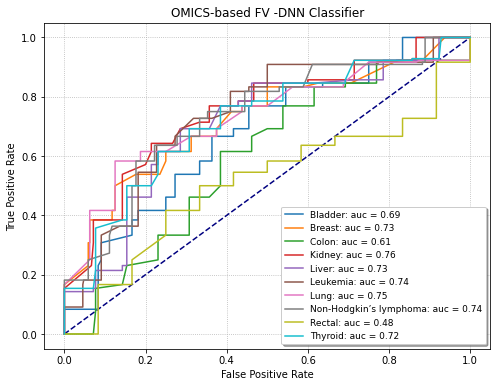

In [12]:
# plot the roc curve for the omics models
pyplot.figure(figsize=[8, 6])
pyplot.grid(b=None, which='major', axis='both',linestyle=':')
pyplot.plot([0, 1], [0, 1], color='navy', lw=1.5, linestyle='dashed')
pyplot.plot(DL_omCancerFPR[0], DL_omCancerTPR[0],label='Bladder: auc = %0.2f' % np.array(DL_omCancerAUC[0]).mean())
pyplot.plot(DL_omCancerFPR[1], DL_omCancerTPR[1],label='Breast: auc = %0.2f' % np.array(DL_omCancerAUC[1]).mean())
pyplot.plot(DL_omCancerFPR[2], DL_omCancerTPR[2],label='Colon: auc = %0.2f' % np.array(DL_omCancerAUC[2]).mean())
pyplot.plot(DL_omCancerFPR[3], DL_omCancerTPR[3],label='Kidney: auc = %0.2f' % np.array(DL_omCancerAUC[3]).mean())
pyplot.plot(DL_omCancerFPR[4], DL_omCancerTPR[4],label='Liver: auc = %0.2f' % np.array(DL_omCancerAUC[4]).mean())
pyplot.plot(DL_omCancerFPR[5], DL_omCancerTPR[5],label='Leukemia: auc = %0.2f' % np.array(DL_omCancerAUC[5]).mean())
pyplot.plot(DL_omCancerFPR[6], DL_omCancerTPR[6],label='Lung: auc = %0.2f' % np.array(DL_omCancerAUC[6]).mean())
pyplot.plot(DL_omCancerFPR[7], DL_omCancerTPR[7],label='Non-Hodgkin’s lymphoma: auc = %0.2f' % np.array(DL_omCancerAUC[7]).mean())
pyplot.plot(DL_omCancerFPR[8], DL_omCancerTPR[8],label='Rectal: auc = %0.2f' % np.array(DL_omCancerAUC[8]).mean())
pyplot.plot(DL_omCancerFPR[9], DL_omCancerTPR[9],label='Thyroid: auc = %0.2f' % np.array(DL_omCancerAUC[9]).mean())

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title('OMICS-based FV -DNN Classifier')

# show the legend
pyplot.legend(loc='best',fontsize = 9,shadow=True)
# pyplot.savefig('Figures/OMICS_FV_DNN_10Cancers.jpeg')
# show the plot
pyplot.show()

## OncoDT-DL Embeddings-based FV

In [66]:
## Define the DL Model
input_dim = 1024
DL_model = Sequential()
DL_model.add(Dense(64, input_dim=input_dim, kernel_initializer='normal', activation='relu'))
# DL_model.add(Dropout(0.2))
DL_model.add(Dense(32,  activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
DL_model.add(Dense(1, activation='sigmoid'))

In [67]:
cancertypes = ["Bladder","Breast", "Colon", "Kidney", "Liver","Luk", 
               "Lung", "NonHodgkinLymph", "Rectal", "Thyroid" ]

DL_emCancerAUC = []
DL_emCancerFPR= []
DL_emCancerTPR= []

for cancer in cancertypes:
    print('\n*Working with '+ cancer + " Cancer*" )
    
    ## Read  combined genes (positive and negative genes) per Cancer
    Genes = pd.read_csv('Datasets/combinedGenes_cancer/'+str(cancer)+'_Genes.csv')
    
    ## Read generated BERT embeddings for each genes
    Embed = np.genfromtxt('BERT_Embed/'+str(cancer)+'_Embed.txt')
    Embed_df = pd.DataFrame(Embed)
    
    ## The embeddings have the same order of the combined genes, 
    #  so concat them using the index
    allG_em = pd.merge(Genes, Embed_df,right_index=True,left_index=True) 
    
    ## Read gene mutation and gene expression
    GE = pd.read_csv('Datasets/OMICS/'+str(cancer)+'_gene_exp.csv')
    Mu = pd.read_csv('Datasets/OMICS/'+str(cancer)+'_gene_mut.csv')
    OMICS = pd.merge(GE, Mu, on=['Gene'], how='inner') 
    CncerOM = OMICS[["Gene","MAX","AVG","MED","MIN","COUNT"]]
    
    CancerFV = pd.merge(allG_em, CncerOM, on=['Gene'], how='outer')
    CancerFV = CancerFV[CancerFV['Label'].notna()]
    CancerFV = CancerFV.fillna(0)

    FV = CancerFV.drop(["Gene", "Sequence","Label","MAX","AVG","MED","MIN","COUNT"], axis=1)
    X = np.array(FV)
    Y = np.array(CancerFV['Label'],dtype=int)

    print('Features and Label shapes', X.shape, Y.shape)
    print('+++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
    
    # all evaluation lists
    auc = []
    fpr = []
    tpr = []
    
    # Compile model
    DL_model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])
    
    foldCounter = 1  
    # Start training and testing
    for train_index, test_index in  skf.split(X,Y):

        print("*** Working with Fold %i :***" %foldCounter)
        #Apply normalization using MaxAbsolute normlization
        max_abs_scaler = MinMaxScaler()
        X_train = max_abs_scaler.fit(X[train_index]) 
        X_train_transform = max_abs_scaler.transform(X[train_index])
        X_test_transform = max_abs_scaler.transform(X[test_index])

        DL_model.fit(X_train_transform, Y[train_index], epochs=20, 
                 batch_size=16)
        predictedScore = DL_model.predict(X_test_transform)
        #  our model's predictions.
        predictedClass= np.argmax(predictedScore, axis=0)

        #print("@@ Validation and evaluation of fold %i @@" %foldCounter)
        fr, tr, _ = roc_curve(Y[test_index], predictedScore)
        fpr.append(fr)
        tpr.append(tr)
        #print("AUC =  %f" %roc_auc_score(Y[test_index], predictedScore))
        auc.append(roc_auc_score(Y[test_index], predictedScore))

        print('------------------------------------------------------')
        foldCounter += 1
   
    #----------------------------------------------------------
    Fpr = np.array(sorted(list(itertools.chain.from_iterable(fpr))))
    Tpr = np.array(sorted(list(itertools.chain.from_iterable(tpr))))
    #-------------------------------------------------
    ### Print Evaluation Metrics.......................
    print("Results:AUC = " + str( np.array(auc).mean().round(decimals=4) ))
    
    DL_aucROC = np.array(auc).mean().round(decimals=4)
    DL_emCancerAUC.append(np.array(DL_aucROC).mean())
    DL_emCancerFPR.append(Fpr)
    DL_emCancerTPR.append(Tpr)

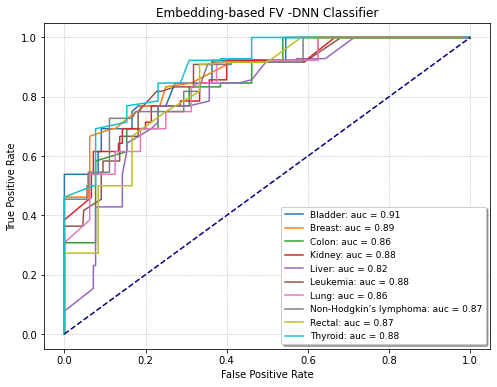

In [96]:
# plot the roc curve for the model
pyplot.figure(figsize=[8, 6])
pyplot.plot([0, 1], [0, 1], color='navy', lw=1.5, linestyle='dashed')
pyplot.grid(b=None, which='major', axis='both',linestyle=':')
pyplot.plot(DL_emCancerFPR[0], DL_emCancerTPR[0],label='Bladder: auc = %0.2f' % np.array(DL_emCancerAUC[0]).mean())
pyplot.plot(DL_emCancerFPR[1], DL_emCancerTPR[1],label='Breast: auc = %0.2f' % np.array(DL_emCancerAUC[1]).mean())
pyplot.plot(DL_emCancerFPR[2], DL_emCancerTPR[2],label='Colon: auc = %0.2f' % np.array(DL_emCancerAUC[2]).mean())
pyplot.plot(DL_emCancerFPR[3], DL_emCancerTPR[3],label='Kidney: auc = %0.2f' % np.array(DL_emCancerAUC[3]).mean())
pyplot.plot(DL_emCancerFPR[4], DL_emCancerTPR[4],label='Liver: auc = %0.2f' % np.array(DL_emCancerAUC[4]).mean())
pyplot.plot(DL_emCancerFPR[5], DL_emCancerTPR[5],label='Leukemia: auc = %0.2f' % np.array(DL_emCancerAUC[5]).mean())
pyplot.plot(DL_emCancerFPR[6], DL_emCancerTPR[6],label='Lung: auc = %0.2f' % np.array(DL_emCancerAUC[6]).mean())
pyplot.plot(DL_emCancerFPR[7], DL_emCancerTPR[7],label='Non-Hodgkin’s lymphoma: auc = %0.2f' % np.array(DL_emCancerAUC[7]).mean())
pyplot.plot(DL_emCancerFPR[8], DL_emCancerTPR[8],label='Rectal: auc = %0.2f' % np.array(DL_emCancerAUC[8]).mean())
pyplot.plot(DL_emCancerFPR[9], DL_emCancerTPR[9],label='Thyroid: auc = %0.2f' % np.array(DL_emCancerAUC[9]).mean())

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title('Embedding-based FV -DNN Classifier')

# show the legend
pyplot.legend(loc='best',fontsize = 9,shadow=True)
# pyplot.legend(bbox_to_anchor=(1.05, 1.0, 0.1, 0.1), loc='best',fontsize = 9)
pyplot.savefig('Figures/Embeddings_FV_DNN_10Cancers.jpeg')
# show the plot
pyplot.show()

## OncoDT-DL Integrated-based FV (OMICS+Embeddings)

In [77]:
## OncoDT-DL OMICS-based FV
## Define the Classifiers
input_dim = 1029
DL_model = Sequential()
DL_model.add(Dense(64, input_dim=input_dim, kernel_initializer='normal', activation='tanh'))
# DL_model.add(Dropout(0.2))
DL_model.add(Dense(32,  activation='tanh', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
DL_model.add(Dense(1, activation='sigmoid'))

In [78]:
DL_CancerAUC = []
DL_CancerFPR= []
DL_CancerTPR= []

for cancer in cancertypes:
    print('\n*Working with '+ cancer + " Cancer*" )
    
    ## Read  combined genes (positive and negative genes) per Cancer
    Genes = pd.read_csv('Datasets/combinedGenes_cancer/'+str(cancer)+'_Genes.csv')
    
    ## Read generated BERT embeddings for each genes
    Embed = np.genfromtxt('BERT_Embed/'+str(cancer)+'_Embed.txt')
    Embed_df = pd.DataFrame(Embed)
    
    ## The embeddings have the same order of the combined genes, 
    #  so concat them using the index
    allG_em = pd.merge(Genes, Embed_df,right_index=True,left_index=True) 
    
    ## Read gene mutation and gene expression
    GE = pd.read_csv('Datasets/OMICS/'+str(cancer)+'_gene_exp.csv')
    Mu = pd.read_csv('Datasets/OMICS/'+str(cancer)+'_gene_mut.csv')
    
    OMICS = pd.merge(GE, Mu, on=['Gene'], how='inner') 
    CncerOM = OMICS[["Gene","MAX","AVG","MED","MIN","COUNT"]]
    
    CancerFV = pd.merge(allG_em, CncerOM, on=['Gene'], how='outer')
    CancerFV = CancerFV[CancerFV['Label'].notna()]
    CancerFV = CancerFV.fillna(0)

    FV = CancerFV.drop(["Gene", "Sequence","Label"], axis=1)
    X = np.array(FV)
    Y = np.array(CancerFV['Label'],dtype=int)

    print('Features and Label shapes', X.shape, Y.shape)
    print('+++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
    
    # all evaluation lists
    auc = []
    fpr = []
    tpr = []
    
    # Compile model
    DL_model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])
    
    foldCounter = 1  
    # Start training and testing
    for train_index, test_index in  skf.split(X,Y):

        print("*** Working with Fold %i :***" %foldCounter)
        #Apply normalization using MaxAbsolute normlization
        max_abs_scaler = MinMaxScaler()
        X_train = max_abs_scaler.fit(X[train_index]) 
        X_train_transform = max_abs_scaler.transform(X[train_index])
        X_test_transform = max_abs_scaler.transform(X[test_index])

        DL_model.fit(X_train_transform, Y[train_index], epochs=20, 
                 batch_size=16)
        predictedScore = DL_model.predict(X_test_transform)
        #  our model's predictions.
        predictedClass= np.argmax(predictedScore, axis=0)

        #print("@@ Validation and evaluation of fold %i @@" %foldCounter)
        fr, tr, _ = roc_curve(Y[test_index], predictedScore)
        fpr.append(fr)
        tpr.append(tr)
        #print("AUC =  %f" %roc_auc_score(Y[test_index], predictedScore))
        auc.append(roc_auc_score(Y[test_index], predictedScore))

        print('------------------------------------------------------')
        foldCounter += 1
   
    #----------------------------------------------------------
    Fpr = np.array(sorted(list(itertools.chain.from_iterable(fpr))))
    Tpr = np.array(sorted(list(itertools.chain.from_iterable(tpr))))
    #-------------------------------------------------
    ### Print Evaluation Metrics.......................
    print("Results:AUC = " + str( np.array(auc).mean().round(decimals=4) ))
    
    DL_aucROC = np.array(auc).mean().round(decimals=4)
    DL_CancerAUC.append(np.array(DL_aucROC).mean())
    DL_CancerFPR.append(Fpr)
    DL_CancerTPR.append(Tpr)

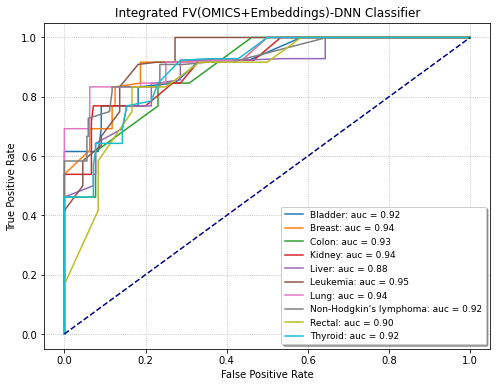

In [97]:
# plot the roc curve for the integrated FV models
pyplot.figure(figsize=[8, 6])

pyplot.plot(DL_CancerFPR[0], DL_CancerTPR[0],label='Bladder: auc = %0.2f' % np.array(DL_CancerAUC[0]).mean())
pyplot.plot(DL_CancerFPR[1], DL_CancerTPR[1],label='Breast: auc = %0.2f' % np.array(DL_CancerAUC[1]).mean())
pyplot.plot(DL_CancerFPR[2], DL_CancerTPR[2],label='Colon: auc = %0.2f' % np.array(DL_CancerAUC[2]).mean())
pyplot.plot(DL_CancerFPR[3], DL_CancerTPR[3],label='Kidney: auc = %0.2f' % np.array(DL_CancerAUC[3]).mean())
pyplot.plot(DL_CancerFPR[4], DL_CancerTPR[4],label='Liver: auc = %0.2f' % np.array(DL_CancerAUC[4]).mean())
pyplot.plot(DL_CancerFPR[5], DL_CancerTPR[5],label='Leukemia: auc = %0.2f' % np.array(DL_CancerAUC[5]).mean())
pyplot.plot(DL_CancerFPR[6], DL_CancerTPR[6],label='Lung: auc = %0.2f' % np.array(DL_CancerAUC[6]).mean())
pyplot.plot(DL_CancerFPR[7], DL_CancerTPR[7],label='Non-Hodgkin’s lymphoma: auc = %0.2f' % np.array(DL_CancerAUC[7]).mean())
pyplot.plot(DL_CancerFPR[8], DL_CancerTPR[8],label='Rectal: auc = %0.2f' % np.array(DL_CancerAUC[8]).mean())
pyplot.plot(DL_CancerFPR[9], DL_CancerTPR[9],label='Thyroid: auc = %0.2f' % np.array(DL_CancerAUC[9]).mean())
pyplot.plot([0, 1], [0, 1], color='navy', lw=1.5, linestyle='dashed')

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title('Integrated FV(OMICS+Embeddings)-DNN Classifier')
pyplot.grid(b=None, which='major', axis='both',linestyle=':')

# show the legend
pyplot.legend(loc='best',fontsize = 9,shadow=True)
# pyplot.savefig('Figures/Integrated_FV_DNN_10Cancers.jpeg')
# show the plot
pyplot.show()

In [ ]:
## END of the Code